# Game Outcome Model

This notebook will test a number of classifier and logistic regression models to predict game outcome.

Models Include:
- Logistic Regression
- Decision Tree
- Random Forest

## Load Libraries

In [1]:
import os
import sys
import warnings

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from ipywidgets import interact, interactive
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import NMF, PCA

%matplotlib inline
pd.set_option("display.max_colwidth", 200)
pd.set_option('display.max_columns', None)

## Set Folder Path

In [2]:
# Navigate two folders up
#os.chdir(os.path.join(os.getcwd(), ".."))

os.chdir("/Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard/")

# Print the new working directory
print("Working In:", os.getcwd())

Working In: /Users/dusty/Desktop/projects/sports_analytics.nosync/fantasy_wizard


## Load Data

In [3]:
# Load rb data
game_data = pd.read_csv(os.path.join(os.getcwd(), "data", "processed", "games", "modeling_game_data.csv"))

## Investigate Data

In [4]:
game_data.shape

(3428, 86)

In [5]:
game_data.head()

,game_id,season,week,team,game_type,home_away,stadium_id,weekday,game_window,qb,coach,opposing_qb,opposing_coach,apy_cap_pct,years_left,home_rest,away_rest,div_game,roof,temp_conditions,wind_conditions,spread_line,points_scored,points_allowed,favored,score,result,rolling_win_pct,rolling_off_ppg,rolling_off_pypg,rolling_off_rypg,rolling_off_typg,rolling_off_ptdpg,rolling_off_rtdpg,rolling_off_ttdpg,rolling_def_ppg,rolling_def_pypg,rolling_def_rypg,rolling_def_typg,rolling_def_ptdpg,rolling_def_rtdpg,rolling_def_ttdpg,rolling_avg_time_to_throw,rolling_avg_completed_air_yards,rolling_avg_intended_air_yards,rolling_avg_air_yards_differential,rolling_avg_attempts,rolling_avg_pass_yards,rolling_avg_pass_touchdowns,rolling_avg_interceptions,rolling_avg_passer_rating,rolling_avg_completions,rolling_avg_completion_percentage,rolling_avg_expected_completion_percentage,rolling_avg_completion_percentage_above_expectation,rolling_avg_avg_air_distance,rolling_avg_max_air_distance,rolling_n_on_report,rolling_n_on_practice_report,prev_season_win_pct,prev_season_off_ppg,prev_season_off_plays_per_game,prev_season_off_run_pct,prev_season_off_pass_pct,prev_season_off_pypg,prev_season_off_rypg,prev_season_off_typg,prev_season_off_ptdpg,prev_season_off_rtdpg,prev_season_off_ttdpg,prev_season_off_fdpg,prev_season_off_spg,prev_season_off_ipg,prev_season_def_ppg,prev_season_def_plays_per_game,prev_season_def_run_pct,prev_season_def_pass_pct,prev_season_def_pypg,prev_season_def_rypg,prev_season_def_typg,prev_season_def_ptdpg,prev_season_def_rtdpg,prev_season_def_ttdpg,prev_season_def_fdpg,prev_season_def_spg,prev_season_def_ipg
0,2016_06_NYJ_ARI,2016,6,ARI,REG,home,PHO00,Monday,evening,Carson Palmer,Bruce Arians,Ryan Fitzpatrick,Todd Bowles,0.135,1,long,medium,0,closed,indoor,indoor,7.5,28,3,1,28.0,1,0.500000,26.00,247.25,121.25,368.50,1.50,1.25,2.75,19.50,173.00,122.50,295.50,1.00,1.25,2.25,2.568050,9.126232,12.123311,-2.997080,38.666667,293.000000,1.333333,1.666667,82.401235,22.000000,57.518519,55.122602,2.395917,25.903123,55.266494,1,1,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
1,2016_08_ARI_CAR,2016,8,ARI,REG,away,CAR00,Sunday,morning,Carson Palmer,Bruce Arians,Carson Palmer,Bruce Arians,0.135,1,long,medium,0,outdoors,hot,low,2.5,20,30,0,20.0,0,0.666667,20.00,238.50,149.25,387.75,1.00,1.25,2.25,11.75,196.00,69.50,265.50,0.75,0.50,1.25,2.513268,7.260870,9.700391,-2.439521,39.666667,281.000000,0.666667,0.333333,87.063344,25.000000,63.573207,59.439515,4.133692,23.275443,53.972586,2,3,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
2,2016_10_SF_ARI,2016,10,ARI,REG,home,PHO00,Sunday,afternoon,Carson Palmer,Bruce Arians,Colin Kaepernick,Chip Kelly,0.135,1,long,medium,1,closed,indoor,indoor,14.0,23,20,1,23.0,1,0.666667,21.75,242.00,125.75,367.75,1.50,1.25,2.75,15.00,186.25,94.25,280.50,0.25,1.00,1.25,2.559281,6.447333,8.858048,-2.410714,43.000000,306.000000,1.333333,0.333333,95.299388,29.000000,67.639230,61.693553,5.945677,21.792187,53.505003,1,3,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
3,2016_11_ARI_MIN,2016,11,ARI,REG,away,MIN01,Sunday,morning,Carson Palmer,Bruce Arians,Carson Palmer,Bruce Arians,0.135,1,medium,medium,0,dome,indoor,indoor,2.0,24,30,0,24.0,0,0.666667,19.25,303.75,102.25,406.00,1.25,1.00,2.25,14.75,202.00,77.25,279.25,0.25,0.75,1.00,2.623836,7.024667,10.076353,-3.051686,48.000000,360.333333,1.333333,1.0

### Numeric Variable Selection

In [34]:
numeric_vars = []

varset_1 = [26] + list(range(1, 20))
#sns.pairplot(game_data.iloc[:,varset_1], hue='result')    

In [24]:
numeric_vars = numeric_vars + ['season', 'apy_cap_pct', 'years_left']

In [35]:
varset_2 = list(set([26] + list(range(21, 30))))
#sns.pairplot(game_data.iloc[:,varset_2], hue='result')   

In [26]:
numeric_vars = numeric_vars + ['favored', 'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg']

In [36]:
varset_3 = [26] + list(range(31, 40))
#sns.pairplot(game_data.iloc[:,varset_3], hue='result')   

In [27]:
numeric_vars = numeric_vars + ['roll_off_typg', 'rolling_off_ptdpg', 'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_rypg']

In [37]:
varset_4 = [26] + list(range(41, 50))
#sns.pairplot(game_data.iloc[:,varset_4], hue='result')   

In [28]:
numeric_vars = numeric_vars + ['rolling_def_ttdpg', 'rolling_avg_air_yards_differential','rolling_avg_attempts', 'rolling_avg_pass_yards', 'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions']

In [38]:
varset_5 = [26] + list(range(51, 60))
#sns.pairplot(game_data.iloc[:,varset_5], hue='result')   

In [29]:
numeric_vars = numeric_vars + ['prev_season_win_pct']

In [39]:
varset_6 = [26] + list(range(61, 70))
#sns.pairplot(game_data.iloc[:,varset_6], hue='result')   

In [30]:
numeric_vars = numeric_vars + ['prev_season_off_plays_per_game', 'prev_season_off_run_pct', 'prev_season_off_pass_pct', 'prev_season_off_pypg', 'prev_season_off_rypg',
                               'prev_season_off_typg', 'prev_season_off_ptdpg', 'prev_season_off_rtdpg', 'prev_season_off_ttdpg']

In [40]:
varset_7 = [26] + list(range(71, 86))
#sns.pairplot(game_data.iloc[:,varset_7], hue='result')   

In [32]:
numeric_vars = numeric_vars + ['prev_season_off_spg', 'prev_season_off_ipg', 'prev_season_def_ppg', 'prev_season_def_plays_per_game',
                               'prev_season_def_pypg', 'prev_season_def_typg', 'prev_season_def_spg', 'prev_season_def_ipg']

In [33]:
print("Numeric Variables that show variation by game outcome: ", numeric_vars)

Numeric Variables that show variation by game outcome:  ['season', 'apy_cap_pct', 'years_left', 'favored', 'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg', 'roll_off_typg', 'rolling_off_ptdpg', 'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_rypg', 'rolling_def_ttdpg', 'rolling_avg_air_yards_differential', 'rolling_avg_attempts', 'rolling_avg_pass_yards', 'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions', 'prev_season_win_pct', 'prev_season_off_plays_per_game', 'prev_season_off_run_pct', 'prev_season_off_pass_pct', 'prev_season_off_pypg', 'prev_season_off_rypg', 'prev_season_off_typg', 'prev_season_off_ptdpg', 'prev_season_off_rtdpg', 'prev_season_off_ttdpg', 'prev_season_off_spg', 'prev_season_off_ipg', 'prev_season_def_ppg', 'prev_season_def_plays_per_game', 'prev_season_def_pypg', 'prev_season_def_typg', 'prev_season_def_spg', 'prev_season_def_ipg']


### Categorical Variable Selection

In [41]:
game_data.head()

,game_id,season,week,team,game_type,home_away,stadium_id,weekday,game_window,qb,coach,opposing_qb,opposing_coach,apy_cap_pct,years_left,home_rest,away_rest,div_game,roof,temp_conditions,wind_conditions,spread_line,points_scored,points_allowed,favored,score,result,rolling_win_pct,rolling_off_ppg,rolling_off_pypg,rolling_off_rypg,rolling_off_typg,rolling_off_ptdpg,rolling_off_rtdpg,rolling_off_ttdpg,rolling_def_ppg,rolling_def_pypg,rolling_def_rypg,rolling_def_typg,rolling_def_ptdpg,rolling_def_rtdpg,rolling_def_ttdpg,rolling_avg_time_to_throw,rolling_avg_completed_air_yards,rolling_avg_intended_air_yards,rolling_avg_air_yards_differential,rolling_avg_attempts,rolling_avg_pass_yards,rolling_avg_pass_touchdowns,rolling_avg_interceptions,rolling_avg_passer_rating,rolling_avg_completions,rolling_avg_completion_percentage,rolling_avg_expected_completion_percentage,rolling_avg_completion_percentage_above_expectation,rolling_avg_avg_air_distance,rolling_avg_max_air_distance,rolling_n_on_report,rolling_n_on_practice_report,prev_season_win_pct,prev_season_off_ppg,prev_season_off_plays_per_game,prev_season_off_run_pct,prev_season_off_pass_pct,prev_season_off_pypg,prev_season_off_rypg,prev_season_off_typg,prev_season_off_ptdpg,prev_season_off_rtdpg,prev_season_off_ttdpg,prev_season_off_fdpg,prev_season_off_spg,prev_season_off_ipg,prev_season_def_ppg,prev_season_def_plays_per_game,prev_season_def_run_pct,prev_season_def_pass_pct,prev_season_def_pypg,prev_season_def_rypg,prev_season_def_typg,prev_season_def_ptdpg,prev_season_def_rtdpg,prev_season_def_ttdpg,prev_season_def_fdpg,prev_season_def_spg,prev_season_def_ipg
0,2016_06_NYJ_ARI,2016,6,ARI,REG,home,PHO00,Monday,evening,Carson Palmer,Bruce Arians,Ryan Fitzpatrick,Todd Bowles,0.135,1,long,medium,0,closed,indoor,indoor,7.5,28,3,1,28.0,1,0.500000,26.00,247.25,121.25,368.50,1.50,1.25,2.75,19.50,173.00,122.50,295.50,1.00,1.25,2.25,2.568050,9.126232,12.123311,-2.997080,38.666667,293.000000,1.333333,1.666667,82.401235,22.000000,57.518519,55.122602,2.395917,25.903123,55.266494,1,1,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
1,2016_08_ARI_CAR,2016,8,ARI,REG,away,CAR00,Sunday,morning,Carson Palmer,Bruce Arians,Carson Palmer,Bruce Arians,0.135,1,long,medium,0,outdoors,hot,low,2.5,20,30,0,20.0,0,0.666667,20.00,238.50,149.25,387.75,1.00,1.25,2.25,11.75,196.00,69.50,265.50,0.75,0.50,1.25,2.513268,7.260870,9.700391,-2.439521,39.666667,281.000000,0.666667,0.333333,87.063344,25.000000,63.573207,59.439515,4.133692,23.275443,53.972586,2,3,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
2,2016_10_SF_ARI,2016,10,ARI,REG,home,PHO00,Sunday,afternoon,Carson Palmer,Bruce Arians,Colin Kaepernick,Chip Kelly,0.135,1,long,medium,1,closed,indoor,indoor,14.0,23,20,1,23.0,1,0.666667,21.75,242.00,125.75,367.75,1.50,1.25,2.75,15.00,186.25,94.25,280.50,0.25,1.00,1.25,2.559281,6.447333,8.858048,-2.410714,43.000000,306.000000,1.333333,0.333333,95.299388,29.000000,67.639230,61.693553,5.945677,21.792187,53.505003,1,3,0.777778,29.444444,62.722222,0.407772,0.592228,287.277778,113.777778,401.055556,2.166667,0.944444,3.111111,20.777778,1.833333,1.833333,21.222222,61.555556,0.387006,0.612994,237.111111,97.666667,334.777778,1.555556,0.666667,2.222222,16.388889,2.111111,2.111111
3,2016_11_ARI_MIN,2016,11,ARI,REG,away,MIN01,Sunday,morning,Carson Palmer,Bruce Arians,Carson Palmer,Bruce Arians,0.135,1,medium,medium,0,dome,indoor,indoor,2.0,24,30,0,24.0,0,0.666667,19.25,303.75,102.25,406.00,1.25,1.00,2.25,14.75,202.00,77.25,279.25,0.25,0.75,1.00,2.623836,7.024667,10.076353,-3.051686,48.000000,360.333333,1.333333,1.0

## Split into Train, Test, Validation Sets
- 80-20 split
- Validation year will be 2023

In [43]:
# Get Target Columns
target_columns = ['result']

# Separate validation data
validation_season = game_data[game_data['season'] == 2023]
validation_season_x = validation_season.drop(columns=target_columns)
validation_season_y = validation_season.result

# Remove validation season
modeling_seasons = game_data[game_data['season'] != 2023]

# Separate Modeling Data
modeling_data_x = modeling_seasons.drop(columns=target_columns)
modeling_data_y = modeling_seasons.result

# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(
    modeling_data_x, modeling_data_y, train_size=0.8, test_size=0.1, random_state=42
)

modeling_data_span = sorted(set(modeling_data_x.season))
validation_data_span = sorted(set(validation_season_x.season))

print("Modeling Seasons: ", modeling_data_span)
print("Validation Seasons: ", validation_data_span)

Modeling Seasons:  [2016, 2017, 2018, 2019, 2020, 2021, 2022]
Validation Seasons:  [2023]


In [44]:
print(f"Training Data Dimensions: {X_train.shape}")
print(f"Test Data Dimensions: {X_test.shape}")

assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

Training Data Dimensions: (2448, 85)
Test Data Dimensions: (307, 85)


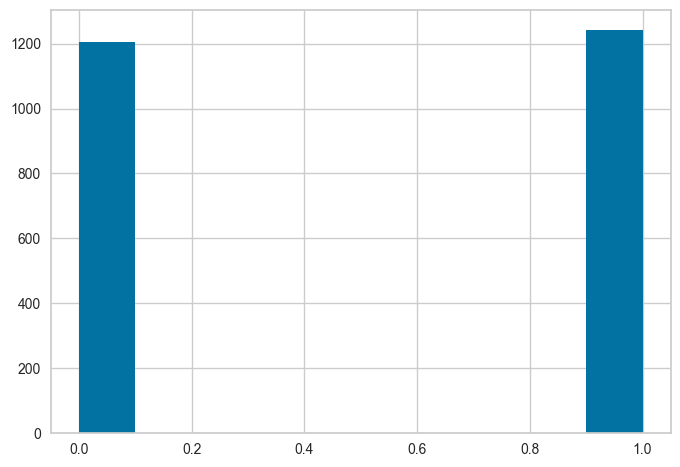

In [46]:
plt.hist(y_train);

## Define Columns for Modeling

In [49]:
modeling_columns = ['apy_cap_pct', 'years_left', 'spread_line',
                   'rolling_win_pct', 'rolling_off_ppg', 'rolling_off_pypg',
                   'rolling_off_rypg', 'rolling_off_typg', 'rolling_off_ptdpg',
                   'rolling_off_rtdpg', 'rolling_off_ttdpg', 'rolling_def_ppg',
                   'rolling_def_pypg', 'rolling_def_rypg', 'rolling_def_typg',
                   'rolling_def_ptdpg', 'rolling_def_rtdpg', 'rolling_def_ttdpg',
                   'rolling_avg_time_to_throw', 'rolling_avg_completed_air_yards',
                   'rolling_avg_intended_air_yards', 'rolling_avg_air_yards_differential',
                   'rolling_avg_attempts', 'rolling_avg_pass_yards',
                   'rolling_avg_pass_touchdowns', 'rolling_avg_interceptions',
                   'rolling_avg_passer_rating', 'rolling_avg_completions',
                   'rolling_avg_completion_percentage',
                   'rolling_avg_expected_completion_percentage',
                   'rolling_avg_completion_percentage_above_expectation',
                   'rolling_avg_avg_air_distance', 'rolling_avg_max_air_distance',
                   'rolling_n_on_report', 'rolling_n_on_practice_report',
                   'prev_season_win_pct', 'prev_season_off_ppg',
                   'prev_season_off_plays_per_game', 'prev_season_off_run_pct',
                   'prev_season_off_pass_pct', 'prev_season_off_pypg',
                   'prev_season_off_rypg', 'prev_season_off_typg', 'prev_season_off_ptdpg',
                   'prev_season_off_rtdpg', 'prev_season_off_ttdpg',
                   'prev_season_off_fdpg', 'prev_season_off_spg', 'prev_season_off_ipg',
                   'prev_season_def_ppg', 'prev_season_def_plays_per_game',
                   'prev_season_def_run_pct', 'prev_season_def_pass_pct',
                   'prev_season_def_pypg', 'prev_season_def_rypg', 'prev_season_def_typg',
                   'prev_season_def_ptdpg', 'prev_season_def_rtdpg',
                   'prev_season_def_ttdpg', 'prev_season_def_fdpg', 'prev_season_def_spg',
                   'prev_season_def_ipg']

drop_columns = ['game_id', 'points_scored', 'points_allowed', 'score']

# Get cat columns
cat_columns = ['season', 'week', 'team', 'game_type', 'home_away',
               'stadium_id', 'weekday', 'game_window', 'qb', 'coach', 'opposing_qb',
               'opposing_coach', 'home_rest', 'away_rest',
               'div_game', 'roof', 'temp_conditions', 'wind_conditions', 'favored']

# Get numeric columns
non_numeric_columns = drop_columns + cat_columns
numeric_columns = X_train.drop(columns=non_numeric_columns).columns

assert(len(numeric_columns) + len(drop_columns) + len(cat_columns) == len(X_train.columns))

In [50]:
# Preprocess Data

# Impute missing data
#imputer = SimpleImputer(strategy="median")
#PCA_data = imputer.fit_transform(modeling_data[numeric_columns])
PCA_data = modeling_data_x[numeric_columns].dropna()

# Create scaling object
scaler = MinMaxScaler()

# Fit scaling object
scaler.fit(modeling_data_x[numeric_columns].dropna())

# Create transformed data
scaled_modeling_data = pd.DataFrame(scaler.transform(modeling_data_x[numeric_columns].dropna()), columns=numeric_columns)

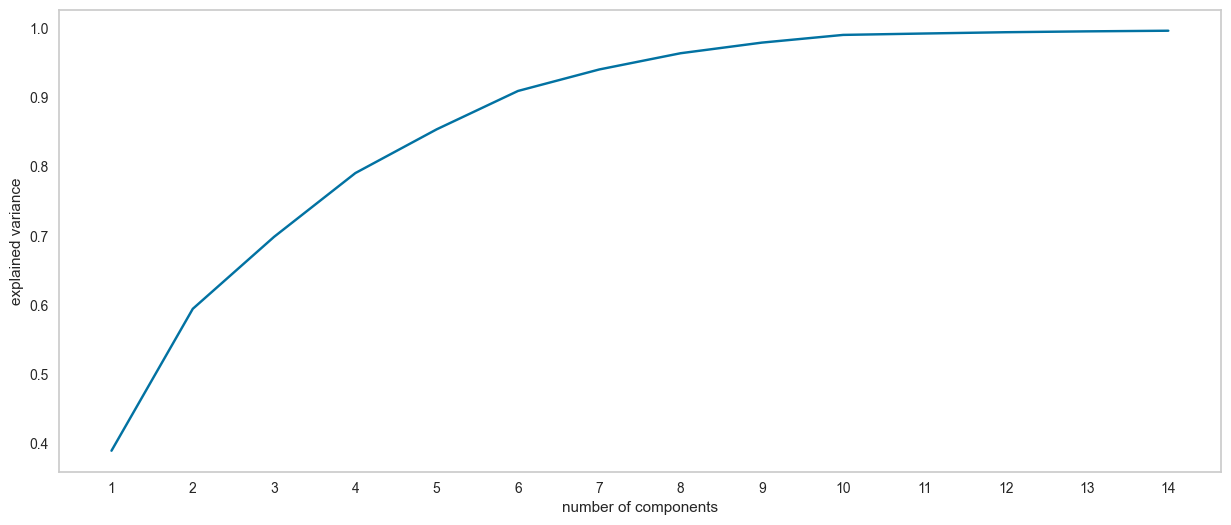

In [53]:
# Creating and fitting the model
pca = PCA(n_components=14, random_state=42).fit(PCA_data)

plt.figure(figsize=(15, 6))
plt.plot(range(1, 15), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, 15))
plt.xlabel("number of components")
plt.ylabel("explained variance")
plt.grid();

In [54]:
np.cumsum(pca.explained_variance_ratio_)

array([0.3892783 , 0.59441638, 0.6984796 , 0.79066386, 0.85388735,
       0.90934286, 0.94043126, 0.96389368, 0.97924813, 0.99038888,
       0.99241543, 0.9942785 , 0.99552429, 0.99643989])

In [55]:
pca.explained_variance_ratio_.sum()

0.9964398901207547

### Summary

*Eight* PCA components explain ~96% of the explained variance in the data, so I will use 8 PCs in this analysis

In [58]:
n_pc = 8

### Define Pipeline

In [59]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse_output=False),
)

preprocessor = make_column_transformer(
    ("drop", drop_columns),
    (numeric_transformer, numeric_columns),
    (categorical_transformer, cat_columns),
)